
number of images to colorize: 1
total number of batches to colorize: 1

created save result path
Image sample_images/JOJO_01_084.png is of size (1500,1977).
The maximum image size allowed is (1500,1500).
It has been resized to (1138,1500)


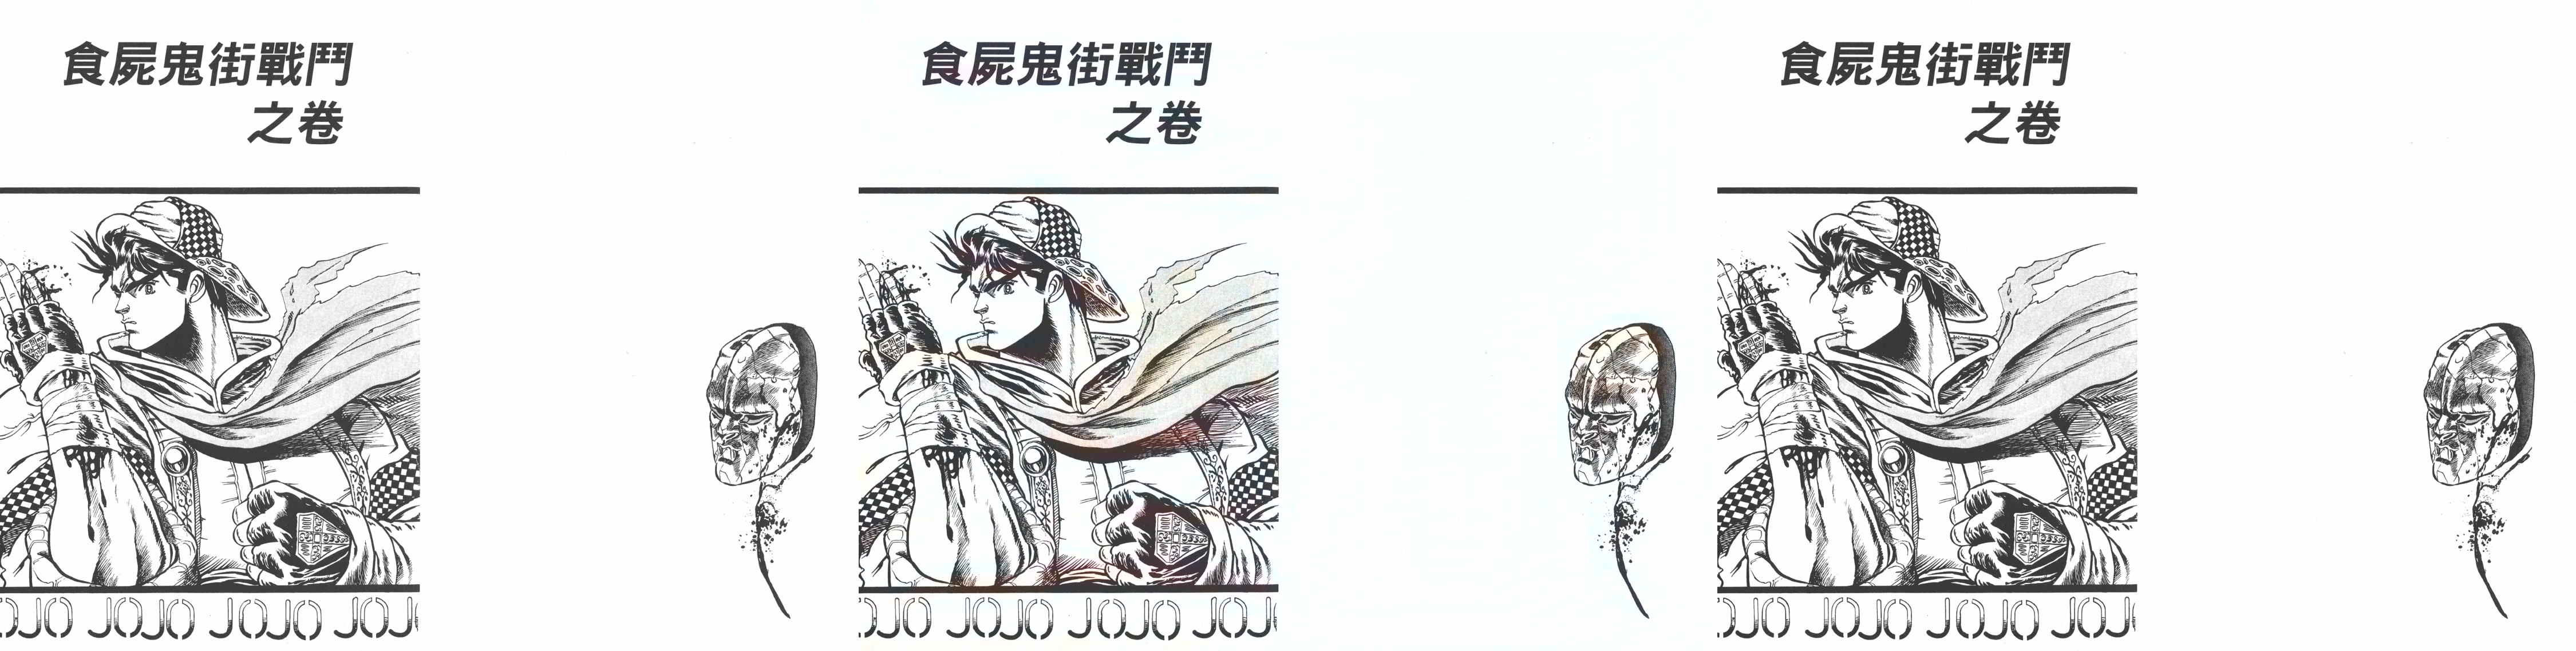


Image 1/1 in batch 1/1. From left to right: grayscale image to colorize, colorized image ( PSNR = 38.58184814 )
and ground truth image. Notice that PSNR has no sense in original black and white images.


average ssim loss = 0.99913907
average psnr loss = 38.58184814


In [ ]:
#Put the model into MODEL/testmodel.h5
#Put the test image into sample_images/test.png
# mv images to sample_images
! if [ ! -d sample_images ] ; \
  then mkdir sample_images; \
fi
!mv *.[pP][nN][gG] *.[jJ][pP][eE][gG] *.[jJ][pP][gG] *.[tT][iI][fF] *.[tT][iI][fF][fF] *.[pP][gG][mM] *.[bB][mM][pP] sample_images/ 2>/dev/null

# ChromaGAN
%tensorflow_version 1.x
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras import applications
from keras.models import load_model
from google.colab.patches import cv2_imshow
import os
import numpy as np
import cv2
import math

# DIRECTORY INFORMATION
DATA_DIR = os.path.join('sample_images/')
OUT_DIR = os.path.join('sample_results/')
MODEL_DIR = os.path.join('MODEL/')
# DATA INFORMATION
BATCH_SIZE = 1
# TRAINING INFORMATION
PRETRAINED = "testmodel.h5" 

class DATA():

    def __init__(self, dirname):
        self.dir_path =dirname
        self.filelist = os.listdir(self.dir_path )
        self.batch_size = BATCH_SIZE
        self.size = len(self.filelist)
        self.data_index = 0

    def read_img(self, filename):
        IMAGE_SIZE = 224
        MAX_SIDE = 1500
        img = cv2.imread(filename, 3)
        if img is None:
          print("Unable to read image: " + filename)
          return False, False, False, False, False
        height, width, channels = img.shape
        if height > MAX_SIDE or width > MAX_SIDE:
          print("Image " + filename + " is of size (" + str(height) + "," + str(width) +  ").")
          print("The maximum image size allowed is (" + str(MAX_SIDE) + "," + str(MAX_SIDE) +  ").")
          r = min(MAX_SIDE/height,MAX_SIDE/width)
          height = math.floor(r*height) 
          width = math.floor(r*width)
          img = cv2.resize(img,(width,height))
          print("It has been resized to (" + str(height) + "," + str(width) + ")")
        labimg = cv2.cvtColor(cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)), cv2.COLOR_BGR2Lab)
        labimg_ori = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        return True, np.reshape(labimg[:,:,0], (IMAGE_SIZE, IMAGE_SIZE, 1)), labimg[:, :, 1:], img, np.reshape(labimg_ori[:,:,0], (height, width, 1))

    def generate_batch(self):
        batch = []
        labels = []
        filelist = []
        labimg_oritList = []
        originalList = [] 
        for i in range(self.batch_size):
            filename = os.path.join(self.dir_path, self.filelist[self.data_index])
            ok, greyimg, colorimg, original, labimg_ori = self.read_img(filename)
            if ok:
              filelist.append(self.filelist[self.data_index])
              batch.append(greyimg)
              labels.append(colorimg)
              originalList.append(original)
              labimg_oritList.append(labimg_ori)
              self.data_index = (self.data_index + 1) % self.size
        batch = np.asarray(batch)/255 # values between 0 and 1
        labels = np.asarray(labels)/255 # values between 0 and 1
        originalList = np.asarray(originalList)
        labimg_oritList = np.asarray(labimg_oritList)/255
        return batch, labels, filelist, originalList, labimg_oritList

def deprocess(imgs):
    imgs = imgs * 255
    imgs[imgs > 255] = 255
    imgs[imgs < 0] = 0
    return imgs.astype(np.uint8)

def reconstruct(batchX, predictedY):
    result = np.concatenate((batchX, predictedY), axis=2)
    result = cv2.cvtColor(result, cv2.COLOR_Lab2BGR)
         
    return result

def sample_images():
    avg_ssim = 0
    avg_psnr = 0
    VGG_modelF = applications.vgg16.VGG16(weights='imagenet', include_top=True) 
    save_path = os.path.join(MODEL_DIR, PRETRAINED)
    colorizationModel = load_model(save_path)
    test_data = DATA(DATA_DIR)
    assert test_data.size >= 0, "Your list of images to colorize is empty. Please load images."
    assert BATCH_SIZE<=test_data.size, "The batch size (" + str(BATCH_SIZE)+ ") should be smaller or equal to the number of testing images (" + str(data_test.size)+ ") --> modify it"
    total_batch = int(test_data.size/BATCH_SIZE)
    print("")
    print("number of images to colorize: " + str(test_data.size))
    print("total number of batches to colorize: " + str(total_batch))
    print("")
    if not os.path.exists(OUT_DIR):
      print('created save result path')
      os.makedirs(OUT_DIR)
    for b in range(total_batch):
            batchX, batchY, filelist, original, labimg_oritList = test_data.generate_batch()
            if batchX.any():
              predY, _ = colorizationModel.predict(np.tile(batchX,[1,1,1,3]))
              predictVGG =VGG_modelF.predict(np.tile(batchX,[1,1,1,3]))
              loss = colorizationModel.evaluate(np.tile(batchX,[1,1,1,3]), [batchY, predictVGG], verbose=0)
              for i in range(BATCH_SIZE):
                  originalResult = original[i]
                  height, width, channels = originalResult.shape
                  predY_2 = deprocess(predY[i])
                  predY_2 = cv2.resize(predY_2, (width,height))
                  labimg_oritList_2 =labimg_oritList[i]
                  predResult_2= reconstruct(deprocess(labimg_oritList_2), predY_2)
                  ssim= tf.keras.backend.eval( tf.image.ssim(tf.convert_to_tensor(originalResult, dtype=tf.float32), tf.convert_to_tensor(predResult_2, dtype=tf.float32), max_val=255))
                  psnr= tf.keras.backend.eval( tf.image.psnr(tf.convert_to_tensor(originalResult, dtype=tf.float32), tf.convert_to_tensor(predResult_2, dtype=tf.float32), max_val=255))
                  avg_ssim += ssim
                  avg_psnr += psnr
                  save_path = os.path.join(OUT_DIR, "{:.8f}_".format(psnr)+filelist[i][:-4] +"_reconstructed.jpg" )
                  cv2_imshow(np.concatenate((np.tile(labimg_oritList[i]*255,[1,1,3]), predResult_2, originalResult),axis=1))
                  cv2.imwrite(save_path, predResult_2)
                  print("")
                  print("Image " + str(i+1) + "/" +str(BATCH_SIZE) + " in batch " + str(b+1) + "/" +str(total_batch) + ". From left to right: grayscale image to colorize, colorized image ( PSNR =", "{:.8f}".format(psnr),")")
                  print("and ground truth image. Notice that PSNR has no sense in original black and white images.")
                  print("")
                  print("")

    print("average ssim loss =", "{:.8f}".format(avg_ssim/(total_batch*BATCH_SIZE)))
    print("average psnr loss =", "{:.8f}".format(avg_psnr/(total_batch*BATCH_SIZE)))


if __name__ == '__main__':
    sample_images()